In [1]:
# ✅ CELDA 1: Instalación de librerías necesarias

!pip install transformers datasets evaluate scikit-learn seaborn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00


# Importamos librerias y el dataset

In [14]:
# ✅ CELDA 2: Importaciones y configuración de semillas

import pandas as pd
import numpy as np
import torch
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import evaluate
import torch.nn as nn

# Fijar semillas para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Distribución de clases:
etiqueta
0     50
1     50
2    260
Name: count, dtype: int64


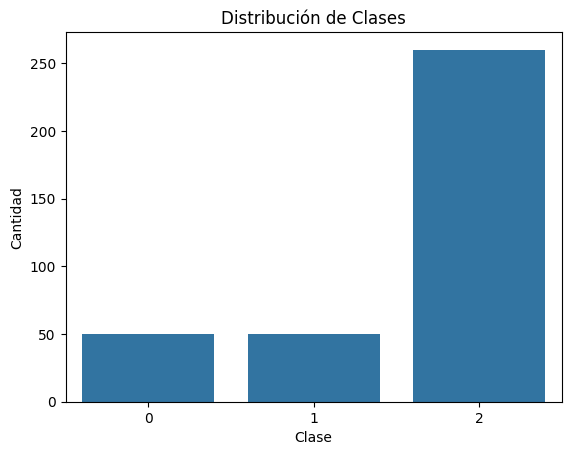

In [13]:
# ✅ CELDA 3: Carga y preprocesamiento de datos

df = pd.read_csv('data.csv')

# Convertir texto a minúsculas
df['texto'] = df['texto'].astype(str).str.lower()

# Revisar clases
conteo = df['etiqueta'].value_counts().sort_index()
print("Distribución de clases:")
print(conteo)

# Graficar distribución de clases
sns.barplot(x=conteo.index, y=conteo.values)
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.title('Distribución de Clases')
plt.show()


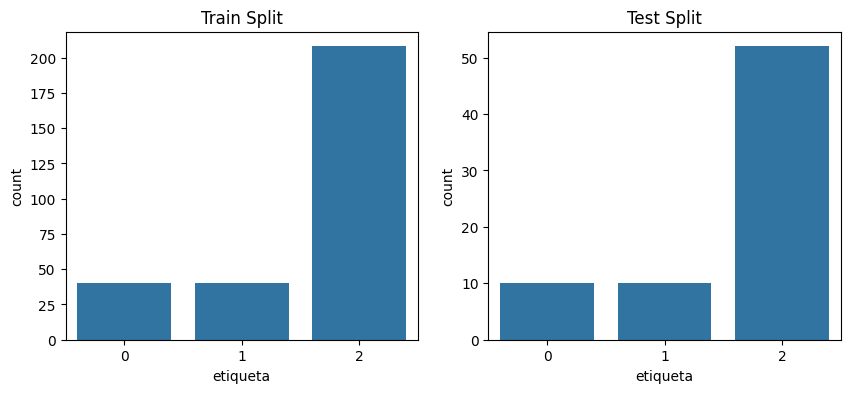

In [15]:
# ✅ CELDA 4: División de datos (consistente)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['etiqueta'], random_state=42)

# Guardar splits para futura consistencia
train_df.to_csv('train_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)

# Visualizar split
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x='etiqueta', data=train_df, ax=ax[0])
ax[0].set_title('Train Split')

sns.countplot(x='etiqueta', data=test_df, ax=ax[1])
ax[1].set_title('Test Split')

plt.show()


# convertimos en un dataset

In [16]:
# ✅ CELDA 5: Preparación del modelo y tokenizador

model_name = "pysentimiento/robertuito-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Función de tokenización
def tokenize_function(example):
    return tokenizer(example["texto"], truncation=True, padding="max_length", max_length=128)

# Dataset de HuggingFace
train_dataset = Dataset.from_pandas(train_df).map(tokenize_function, batched=True)
eval_dataset = Dataset.from_pandas(test_df).map(tokenize_function, batched=True)

# Renombrar columna
train_dataset = train_dataset.rename_column("etiqueta", "labels")
eval_dataset = eval_dataset.rename_column("etiqueta", "labels")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

# Preparacion dle modelo y tokenizador

In [17]:
# ✅ CELDA 6: Pesos de clase y Trainer personalizado

# Pesos según datos de train para balancear clases
conteo_train = train_df['etiqueta'].value_counts().sort_index()
class_counts = torch.tensor(conteo_train.values, dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


# Tokenizacion y division de datos

In [18]:
# ✅ CELDA 7: Configuración del entrenamiento

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    logging_dir='./logs',
    logging_steps=10
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-18-3565471459.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [19]:
# ✅ CELDA 8: Entrenamiento del modelo

trainer.train()
trainer.save_model("robertuito-reentrenado-v2")
tokenizer.save_pretrained("robertuito-reentrenado-v2")


Step,Training Loss
10,1.005500
20,0.808600
30,0.553700
40,0.288800
50,0.233200
60,0.148300
70,0.133000
80,0.074900
90,0.034000
100,0.025600


('robertuito-reentrenado-v2/tokenizer_config.json',
 'robertuito-reentrenado-v2/special_tokens_map.json',
 'robertuito-reentrenado-v2/tokenizer.json')

              precision    recall  f1-score   support

      normal       0.90      0.90      0.90        10
    ansiedad       0.89      0.80      0.84        10
   depresivo       0.96      0.98      0.97        52

    accuracy                           0.94        72
   macro avg       0.92      0.89      0.90        72
weighted avg       0.94      0.94      0.94        72



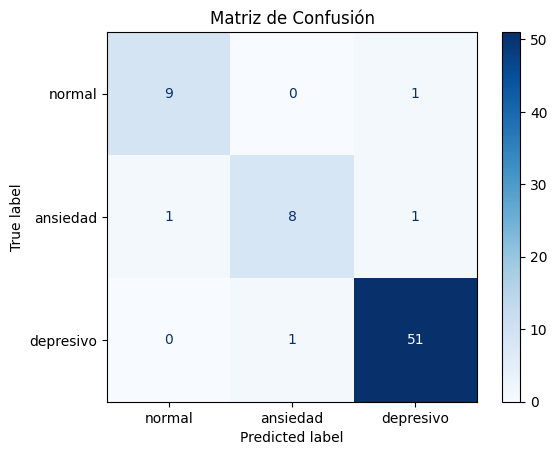

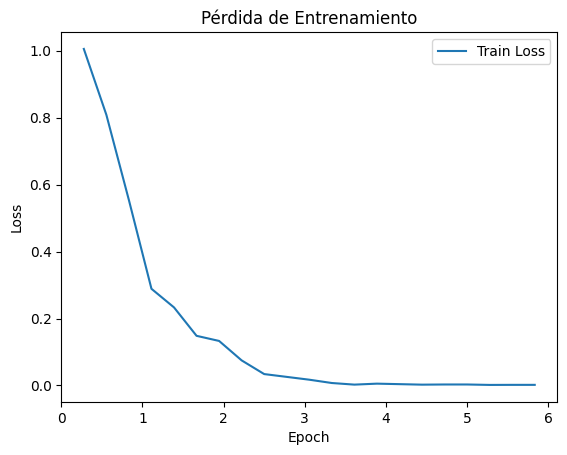

In [20]:
# ✅ CELDA 9: Evaluación y visualización de métricas

predictions = trainer.predict(eval_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=["normal", "ansiedad", "depresivo"]))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["normal", "ansiedad", "depresivo"], cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

# Graficar evolución de métricas
logs = trainer.state.log_history
epochs, train_loss, eval_loss, eval_accuracy = [], [], [], []

for entry in logs:
    if 'loss' in entry and 'epoch' in entry:
        epochs.append(entry['epoch'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
    if 'eval_accuracy' in entry:
        eval_accuracy.append(entry['eval_accuracy'])

plt.plot(epochs[:len(train_loss)], train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida de Entrenamiento')
plt.legend()
plt.show()

if eval_loss:
    plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Eval Loss')
    plt.xlabel('Evaluación #')
    plt.ylabel('Loss')
    plt.title('Pérdida de Evaluación')
    plt.legend()
    plt.show()

if eval_accuracy:
    plt.plot(range(1, len(eval_accuracy)+1), eval_accuracy, label='Eval Accuracy')
    plt.xlabel('Evaluación #')
    plt.ylabel('Accuracy')
    plt.title('Accuracy de Evaluación')
    plt.legend()
    plt.show()


In [23]:
# ✅ CELDA 10: Prueba de predicción manual

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

textos = ["que solitario es el dia"]

inputs = tokenizer(textos, padding=True, truncation=True, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicciones = torch.argmax(logits, dim=1)

id2label = {0: "Otros", 1: "ansiedad", 2: "depresivo"}
print("Predicciones:", [id2label[p.item()] for p in predicciones])


Predicciones: ['depresivo']
